<a href="https://colab.research.google.com/github/Jaseelkt007/Generative_AI_basics/blob/main/Diffusion_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Diffusion models

Implementing the DDPM 2020 paper

* This paper is primarly based on discrete-time Markov chain and variational inference (not directly based on SDE or langavin dynamics)

* Some key information :
  * uses discrete forward diffusion process that gradually adds guassian noise
  *  Employs variational lower bound optimization (Heirarchical VAE)
This has two process:

* DDPM is actually learning to predict the noise e that was added at each step
* The neural network predicts the noise used in the forward process.
* Objective is framed as denoising task (not score matching)
* Forward process (Diffusion process) : Change a give input $x_0$ to a Guassian noise $x_t$ ~ $N(0,I)$ by a sequence of first order markov process $q(x_t/x_{t-1})$ ,

* Reverse process (Generation process) : Reverse the diffustion process, by converting the Noise to original data.

# Some relevent papers:
1. Vincet(2011):
   * Established theoritical foundation connecting denoising and score estimation
   * (See my repository for a detailed explanation and connection to Langevin dynamics: [GitHub_repo](https://github.com/Jaseelkt007/Generative_AI_basics/blob/main/Langvin_sampling.ipynb))
2. Song & Ermon (2019)
   * explicitly formulates generative modeling as score matching
   * Uses Langevin dynamics for sampling
3. Song et al. (2021)
   * Shows DDPM is actually learning score function
   *  proves that predicted noise is equivalent to learning score
   *  provide the SDE framework that unifies various diffusion approached


# Diffusion Model Equations

## Forward/noising (fixed, known):

$$q(\mathbf{x}_t \mid \mathbf{x}_{t-1}) = \mathcal{N}\big(\sqrt{\alpha_t}\,\mathbf{x}_{t-1},\, (1-\alpha_t)\mathbf{I}\big), \qquad \alpha_t = 1 - \beta_t$$

## Closed form:

instead of adding noice step by step(slow) , we can jump from clean data x_0 to any noisy version using x_t (like reparametrization,then sample from it)

$$\mathbf{x}_t = \sqrt{\bar{\alpha}_t}\,\mathbf{x}_0 + \sqrt{1-\bar{\alpha}_t}\,\boldsymbol{\epsilon}$$

where:
$$\bar{\alpha}_t = \prod_{s=1}^t \alpha_s, \qquad \boldsymbol{\epsilon} \sim \mathcal{N}(0,I)$$

## Model & loss (ε-prediction):

$$\mathcal{L} = \mathbb{E}_{\mathbf{x}_0,t,\boldsymbol{\epsilon}}\big[\|\boldsymbol{\epsilon} - \boldsymbol{\epsilon}_\theta(\mathbf{x}_t,t)\|^2\big]$$

## Reverse/denoising (ancestral DDPM step):

$$p_\theta(\mathbf{x}_{t-1}\mid \mathbf{x}_t) = \mathcal{N}\!\big(\boldsymbol{\mu}_\theta(\mathbf{x}_t,t),\ \sigma_t^2 I\big)$$

where:
$$\boldsymbol{\mu}_\theta = \frac{1}{\sqrt{\alpha_t}}\left(\mathbf{x}_t - \frac{\beta_t}{\sqrt{1-\bar{\alpha}_t}}\ \boldsymbol{\epsilon}_\theta(\mathbf{x}_t,t)\right)$$

$$\sigma_t^2 = \beta_t$$

In [82]:
# Create a toy dataset
import math, numpy as np, torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


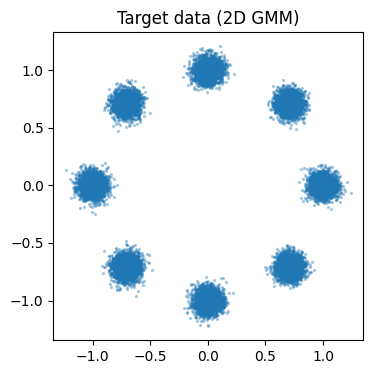

In [93]:
class GMM2D(Dataset):
    def __init__(self, n=3000, std=0.06, K=8):
        self.n = n
        angles = np.linspace(0, 2*np.pi , K , endpoint=False)
        centers = np.stack([np.cos(angles), np.sin(angles)], axis=1).astype(np.float32)
        idx = torch.randint(0,K, (n,))
        base = torch.tensor(centers)[idx]
        self.data = base + std*torch.randn(n,2)

    def __len__(self): return self.n
    def __getitem__(self, i): return self.data[i]

dataset = GMM2D(n=20000, std=0.06)
loader = DataLoader(dataset, batch_size=256, shuffle=True, drop_last=True)

pts = dataset.data.numpy()
plt.figure(figsize=(4,4)); plt.scatter(pts[:,0], pts[:,1], s=2, alpha=0.3)
plt.axis('equal'); plt.title("Target data (2D GMM)"); plt.show()

$$\mathbf{x}_1 = \sqrt{{\alpha}_t}\,\mathbf{x}_0 + \sqrt{1-{\alpha}_t}\,\boldsymbol{\epsilon}$$
$$\mathbf{x}_2 = \sqrt{{\alpha}_t}\,\mathbf{x}_1 + \sqrt{1-{\alpha}_t}\,\boldsymbol{\epsilon}$$
$$=$$
$$\mathbf{x}_2 = \sqrt{{\alpha}_t}\,(\sqrt{{\alpha}_t}\,\mathbf{x}_0 + \sqrt{1-{\alpha}_t}\,\boldsymbol{\epsilon}) + \sqrt{1-{\alpha}_t}\,\boldsymbol{\epsilon}  $$

$$....$$
$$\mathbf{x}_t = \sqrt{\bar{\alpha}_t}\,\mathbf{x}_0 + \sqrt{1-\bar{\alpha}_t}\,\boldsymbol{\epsilon}$$

$$\bar{\alpha}_t = \prod_{s=1}^t \alpha_s, \qquad \boldsymbol{\epsilon} \sim \mathcal{N}(0,I)$$

In [84]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"using device : {device}")
T = 1000
beta_start , beta_end = 1e-4, 2e-2
# Linear schedular : beta decides how quickly we add noise. the DDPM paper uses linear schedular form 1e-2 to 0.02 over 1000 steps
betas = torch.linspace(beta_start, beta_end, T, dtype=torch.float32, device=device)
alphas = 1.0 - betas
abar = torch.cumprod(alphas, dim=0) # cumulative product,

def add_noise(x0, t, noise=None):
    """Add noise to x0 at timestep t using reparameterization trick"""
    if noise is None:
        noise = torch.randn_like(x0)

    if isinstance(t, int):
        t = torch.full((x0.shape[0]), t, device=device) # [t,t,t,t..]
    else:
        t = t.to(device)

    # Simple direct indexing - much cleaner!
    sqrt_abar_t = torch.sqrt(abar[t]).reshape(-1, 1)
    sqrt_one_minus_abar_t = torch.sqrt(1 - abar[t]).reshape(-1, 1)

    xt = sqrt_abar_t * x0 + sqrt_one_minus_abar_t * noise
    return xt, noise




using device : cpu


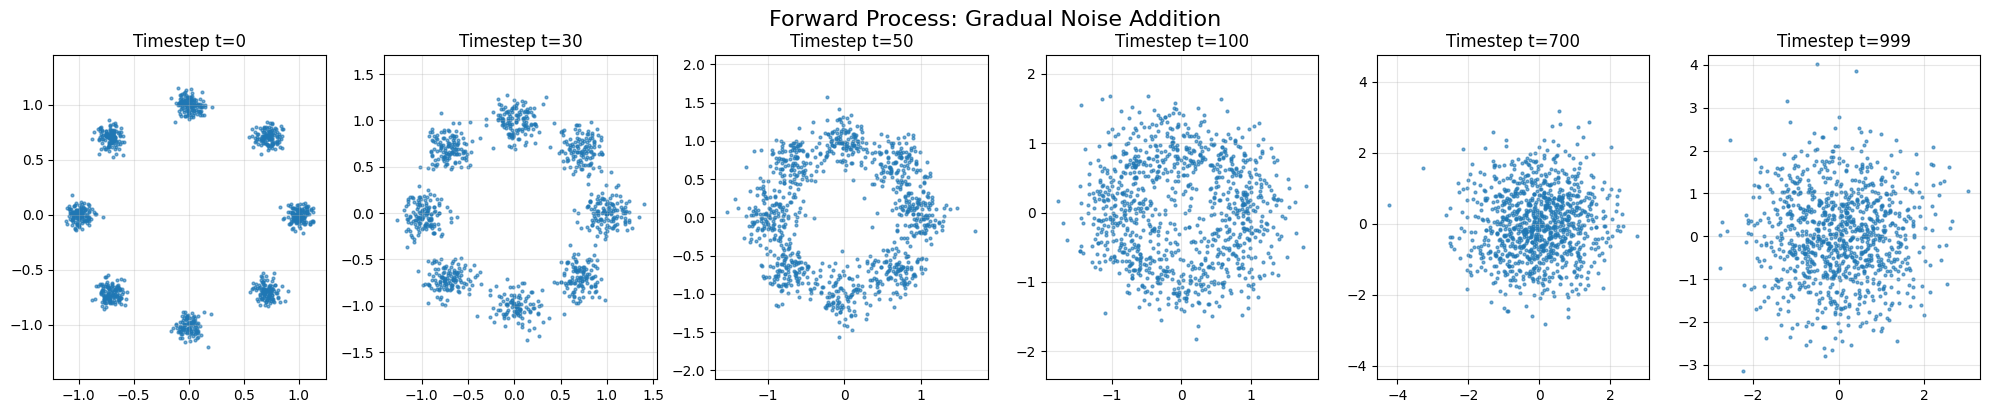

In [85]:
# Visualization of forward process
def visualize_forward_process():
    dataset = GMM2D(n=20000, std=0.06)

    # Sample some data points
    x_0 = dataset.data[:1000].to(device)  # Fix: Move to device

    timestep_to_show = [ 0,30 ,50, 100, 700,999]

    fig, axes = plt.subplots(1, 6, figsize=(20, 4))  # Changed to 1x5 layout

    for i, t in enumerate(timestep_to_show):
        if t == 0:
            x_t = x_0
        else:
            t_tensor = torch.tensor([t] * x_0.shape[0], device=device)
            x_t, _ = add_noise(x_0, t_tensor)

        points = x_t.cpu().numpy()
        axes[i].scatter(points[:, 0], points[:, 1], s=4, alpha=0.6)
        axes[i].set_title(f'Timestep t={t}')
        axes[i].set_xlim(-3, 3)
        axes[i].set_ylim(-3, 3)
        axes[i].axis('equal')
        axes[i].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.suptitle('Forward Process: Gradual Noise Addition', fontsize=16, y=1.02)
    plt.show()

# Run the visualization
visualize_forward_process()


# Denoiser network
The denoiser network takes:
- INPUT  : noisy data x_t + timestep t
- OUTPUT : prediction of the noise e that was added

Once we know the noise, we can substract it to get cleaner data!

$$ Goal :ϵ_θ(x_t, t) ≈ ϵ $$

## Time Embedding
The network needs to know WHEN in the diffusion process we are:
- At t=50: only a little noise was added → predict small noise
- At t=900: lots of noise was added → predict large noise

BUT: Neural networks work with continuous values, not discrete timesteps.

Solution: Assign a unique embedding vector to each timestep (embedding)

In [86]:
import math
class SinTimeEmbed(nn.Module):
    def __init__(self, dim, max_period=10000):
        super().__init__()
        self.dim = dim                  # size of the embedding vector
        self.max_period = max_period    # Controls the frequency range

    def forward(self, t):
        """
        t: Timestep tensor : [B , T-1]
        returns : emb : [B, D] ,  a single timestep for a step.
        """
        half = self.dim//2
        freqs = torch.exp(-math.log(self.max_period)*torch.arange(half, device=t.device)/half) # first half for sine and then cosine
        args  = t.float().unsqueeze(1) * freqs.unsqueeze(0) / (T-1) # Normalize t to 0-1
        emb = torch.cat([torch.cos(args), torch.sin(args)], dim=1) # apply sin and cos to all t's
        if self.dim % 2:
            emb = torch.cat([emb, torch.zeros_like(emb[:, :1])], dim=1)
        return emb


In [94]:
class DenoiserMLP(nn.Module):
    """
    The neural network that learns to predict noise.
    Architecture:
    1. Time embedding: Convert timestep ->> time vector
    2. Concatenate   : [noisy_data, time_embedding]
    3. MLP           : neural network
    4. Output        : Predicted noise (same shape as input data)
    """
    def __init__(self, hidden=256, tdim=128):
        super().__init__()
        self.time = nn.Sequential(
            SinTimeEmbed(tdim),    # turn int timestep → [cos,sin] features
            nn.Linear(tdim, hidden),
            nn.SiLU(),
        )
        self.net = nn.Sequential(
            nn.Linear(2 + hidden, hidden), # 2 = x-dim, hidden = time-dim
            nn.SiLU(),
            nn.Linear(hidden, hidden),
            nn.SiLU(),
            nn.Linear(hidden, 2),         # predict ε of size 2
        )

    def forward(self, x, t):
        temb = self.time(t)            # (B, hidden)
        h    = torch.cat([x, temb], 1) # concat input coords + time embedding
        return self.net(h)

model = DenoiserMLP().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)



In [95]:
# Training Ojective (e - prediction)

def training_step(x0):
    x0 = x0.to(device)
    B = x0.size(0)
    t = torch.randint(0, T, (B,), device=device)
    x_t, actual_noise = add_noise(x0, t)
    predicted_noise = model(x_t, t )
    loss = F.mse_loss(predicted_noise, actual_noise)
    return loss, x_t, actual_noise, predicted_noise, t

# training
def train_ddpm(epochs =10, log_interval=100):
    model.train()
    loss_history = []
    detailed_logs = []

    print("Starting DDPM Training...")
    print("=" * 50)
    for epoch in range(epochs):
        epoch_losses = []

        for batch_idx, batch_data in enumerate(loader):
            # Training step
            optimizer.zero_grad()
            loss, x_t, actual_noise, predicted_noise, timesteps = training_step(batch_data)
            loss.backward()

            # Gradient clipping (prevents exploding gradients)
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

            # Logging
            loss_value = loss.item()
            loss_history.append(loss_value)
            epoch_losses.append(loss_value)

            # Detailed logging every log_interval steps
            if batch_idx % log_interval == 0:
                with torch.no_grad():
                    noise_error = torch.mean((predicted_noise - actual_noise) ** 2).item()
                    avg_timestep = torch.mean(timesteps.float()).item()

                detailed_logs.append({
                    'epoch': epoch,
                    'batch': batch_idx,
                    'loss': loss_value,
                    'noise_error': noise_error,
                    'avg_timestep': avg_timestep,
                    'x_t': x_t[:10].cpu(),  # Save first 10 samples for visualization
                    'actual_noise': actual_noise[:10].cpu(),
                    'predicted_noise': predicted_noise[:10].cpu(),
                    'timesteps': timesteps[:10].cpu()
                })

        # Epoch summary
        avg_epoch_loss = np.mean(epoch_losses)
        print(f"Epoch {epoch+1:02d}: avg_loss = {avg_epoch_loss:.6f}")

    print("\n Training completed!")
    return loss_history, detailed_logs

# Run training
loss_history, detailed_logs = train_ddpm(epochs=10)

Starting DDPM Training...
Epoch 01: avg_loss = 0.705020
Epoch 02: avg_loss = 0.252279
Epoch 03: avg_loss = 0.253979
Epoch 04: avg_loss = 0.249678
Epoch 05: avg_loss = 0.249162
Epoch 06: avg_loss = 0.240170
Epoch 07: avg_loss = 0.242441
Epoch 08: avg_loss = 0.241896
Epoch 09: avg_loss = 0.245021
Epoch 10: avg_loss = 0.237321

 Training completed!


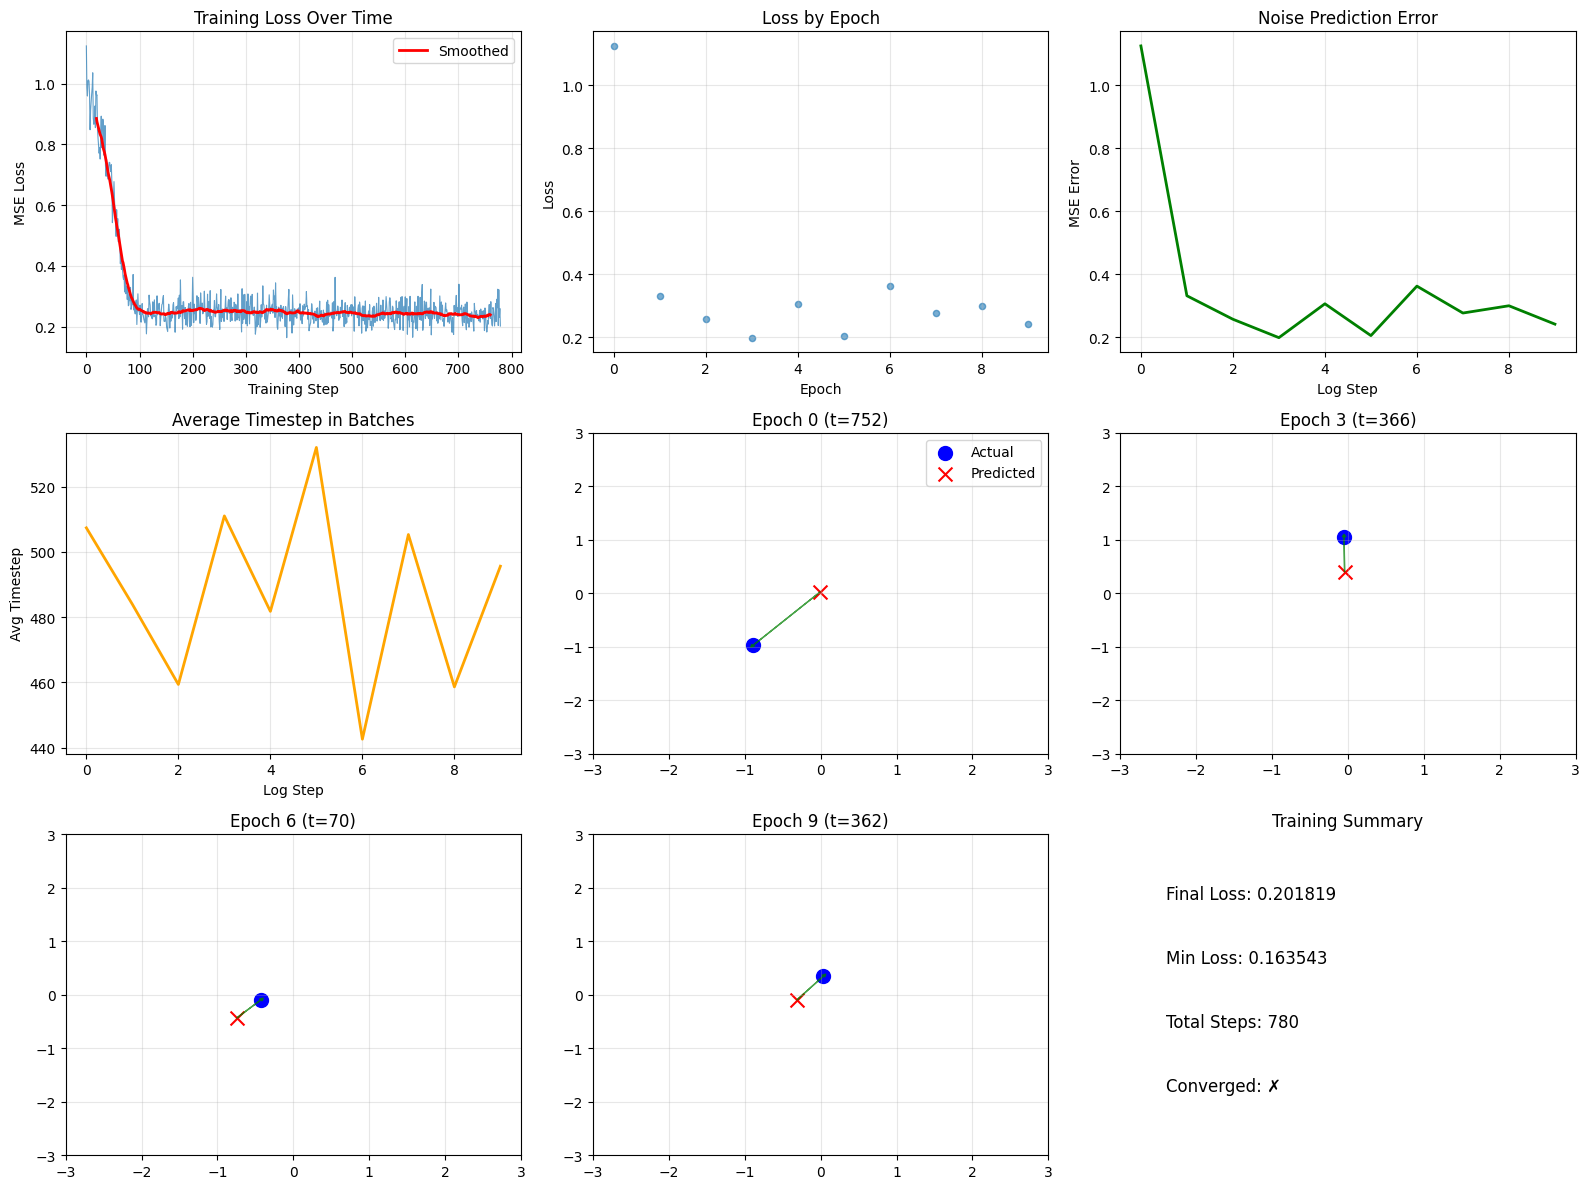

What to Look For:
• Loss should decrease over time (network learning)
• Noise prediction error should improve
• Red X should get closer to blue O (better noise prediction)
• Arrow shows prediction error - should get smaller


In [96]:
def plot_training_progress(loss_history, detailed_logs):
    """Comprehensive training progress visualization"""

    fig = plt.figure(figsize=(16, 12))

    # 1. Loss curve
    ax1 = plt.subplot(3, 3, 1)
    plt.plot(loss_history, alpha=0.7, linewidth=0.8)

    # Add smoothed line
    if len(loss_history) > 50:
        smooth_window = len(loss_history) // 20
        smooth_loss = np.convolve(loss_history, np.ones(smooth_window)/smooth_window, mode='valid')
        plt.plot(range(smooth_window//2, len(loss_history) - smooth_window//2), smooth_loss,
                'red', linewidth=2, label='Smoothed')
        plt.legend()

    plt.title('Training Loss Over Time')
    plt.xlabel('Training Step')
    plt.ylabel('MSE Loss')
    plt.grid(True, alpha=0.3)

    # 2. Loss distribution by epoch
    ax2 = plt.subplot(3, 3, 2)
    epochs = [log['epoch'] for log in detailed_logs]
    losses = [log['loss'] for log in detailed_logs]
    plt.scatter(epochs, losses, alpha=0.6, s=20)
    plt.title('Loss by Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True, alpha=0.3)

    # 3. Noise prediction accuracy over time
    ax3 = plt.subplot(3, 3, 3)
    noise_errors = [log['noise_error'] for log in detailed_logs]
    steps = range(len(noise_errors))
    plt.plot(steps, noise_errors, 'green', linewidth=2)
    plt.title('Noise Prediction Error')
    plt.xlabel('Log Step')
    plt.ylabel('MSE Error')
    plt.grid(True, alpha=0.3)

    # 4. Timestep distribution in training
    ax4 = plt.subplot(3, 3, 4)
    avg_timesteps = [log['avg_timestep'] for log in detailed_logs]
    plt.plot(avg_timesteps, 'orange', linewidth=2)
    plt.title('Average Timestep in Batches')
    plt.xlabel('Log Step')
    plt.ylabel('Avg Timestep')
    plt.grid(True, alpha=0.3)

    # 5-9. Before/After noise prediction examples from different epochs
    example_epochs = [0, len(detailed_logs)//3, 2*len(detailed_logs)//3, -1]
    subplot_positions = [(3, 3, 5), (3, 3, 6), (3, 3, 7), (3, 3, 8)]

    for i, (epoch_idx, pos) in enumerate(zip(example_epochs, subplot_positions)):
        ax = plt.subplot(*pos)
        log_entry = detailed_logs[epoch_idx]

        # Show actual vs predicted noise for first sample
        actual = log_entry['actual_noise'][0].detach().numpy()
        predicted = log_entry['predicted_noise'][0].detach().numpy()
        timestep = log_entry['timesteps'][0].item()

        ax.scatter([actual[0]], [actual[1]], c='blue', s=100, label='Actual', marker='o')
        ax.scatter([predicted[0]], [predicted[1]], c='red', s=100, label='Predicted', marker='x')
        ax.arrow(predicted[0], predicted[1], actual[0]-predicted[0], actual[1]-predicted[1],
                head_width=0.05, head_length=0.05, fc='green', ec='green', alpha=0.7)

        ax.set_title(f'Epoch {log_entry["epoch"]} (t={timestep})')
        ax.set_xlim(-3, 3)
        ax.set_ylim(-3, 3)
        ax.grid(True, alpha=0.3)
        if i == 0:
            ax.legend()

    # Overall loss statistics
    ax9 = plt.subplot(3, 3, 9)
    ax9.text(0.1, 0.8, f"Final Loss: {loss_history[-1]:.6f}", fontsize=12)
    ax9.text(0.1, 0.6, f"Min Loss: {min(loss_history):.6f}", fontsize=12)
    ax9.text(0.1, 0.4, f"Total Steps: {len(loss_history)}", fontsize=12)
    ax9.text(0.1, 0.2, f"Converged: {'✓' if loss_history[-1] < 0.1 else '✗'}", fontsize=12)
    ax9.set_title('Training Summary')
    ax9.axis('off')

    plt.tight_layout()
    plt.show()

# Plot the training progress
plot_training_progress(loss_history, detailed_logs)

print("What to Look For:")
print("• Loss should decrease over time (network learning)")
print("• Noise prediction error should improve")
print("• Red X should get closer to blue O (better noise prediction)")
print("• Arrow shows prediction error - should get smaller")

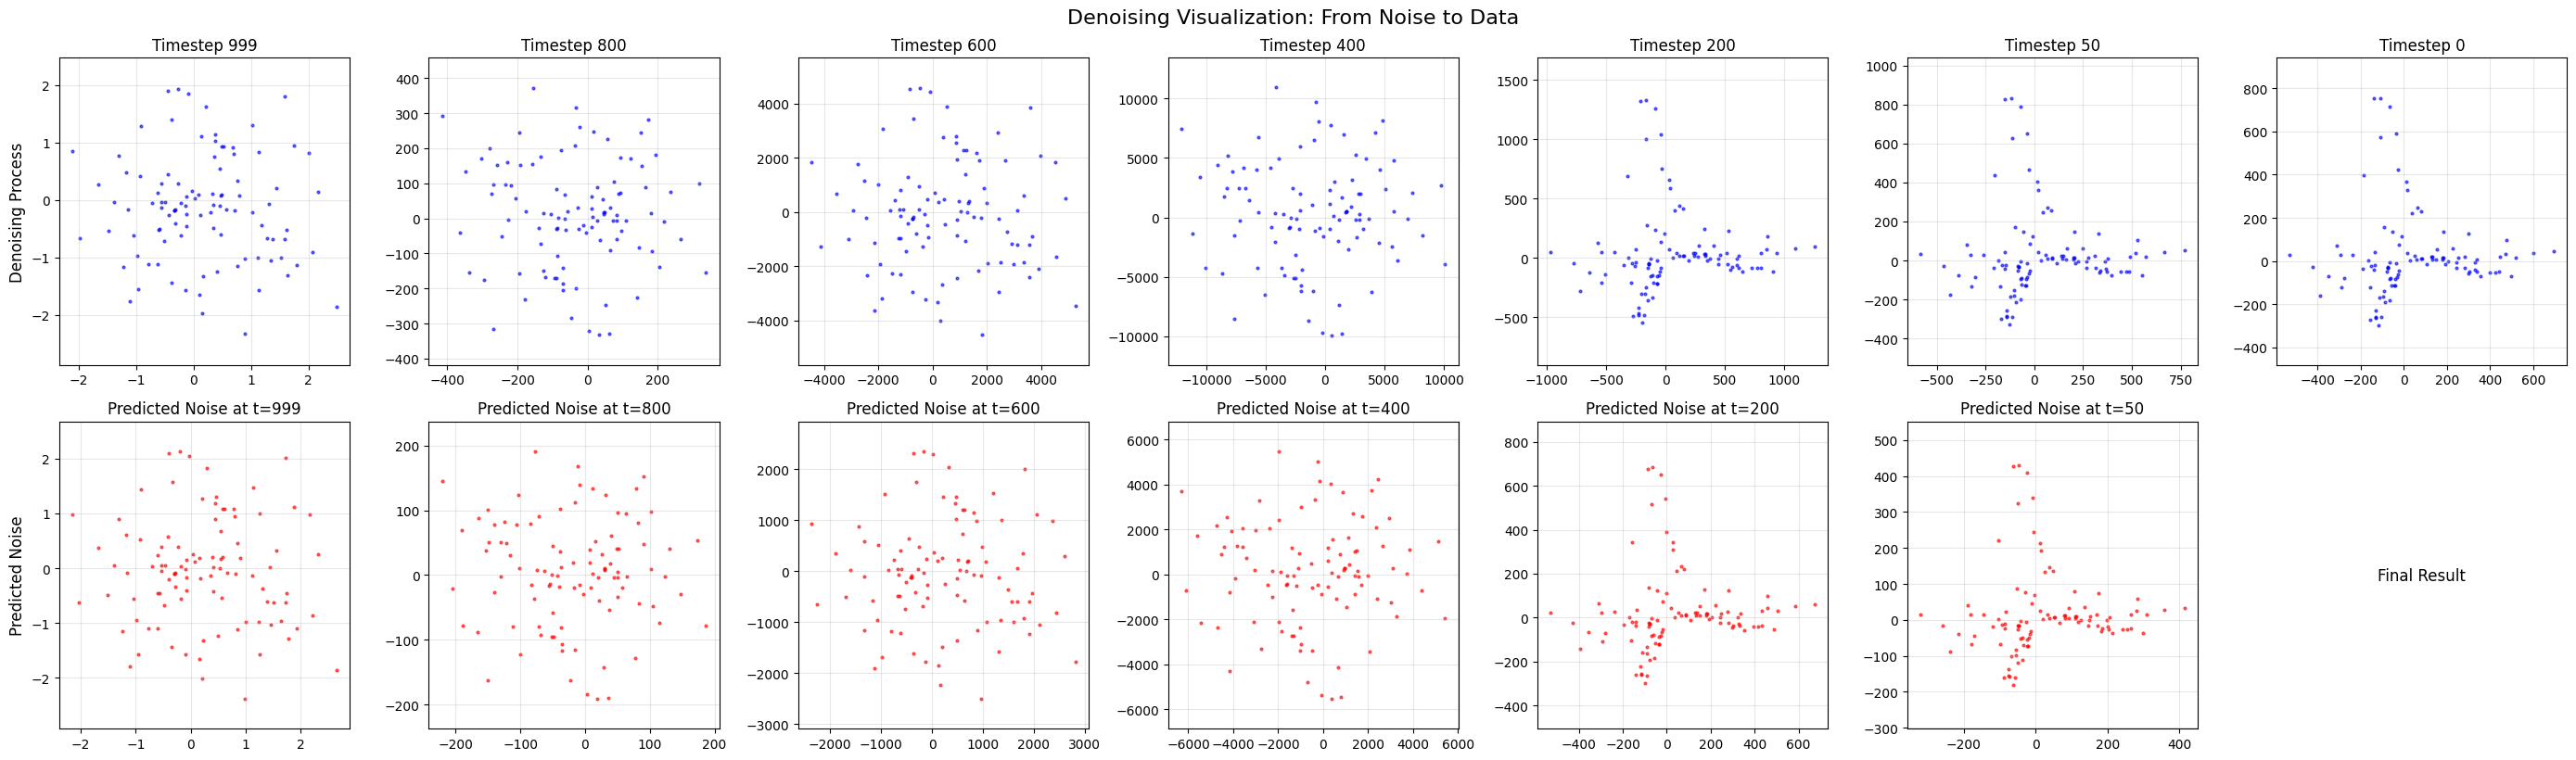

What You Should See:
• Top row: Gradual emergence of GMM structure
• Bottom row: How predicted noise changes over time
• Early timesteps: Large noise predictions
• Later timesteps: Fine-detail noise predictions


In [97]:
def visualize_denoising_process(num_samples=100, timesteps_to_show=None):
    """
    Show how the trained model denoises step by step
    """
    if timesteps_to_show is None:
        timesteps_to_show = [999, 800, 600, 400, 200, 50, 0]

    model.eval()
    with torch.no_grad():
        # Start with pure noise
        x = torch.randn(num_samples, 2, device=device)

        # Store denoising trajectory
        trajectory = [x.cpu().numpy()]
        predicted_noises = []

        # Simulate reverse process (simplified - we'll do proper sampling later)
        for i, t in enumerate(timesteps_to_show[:-1]):
            current_t = torch.full((num_samples,), t, device=device)

            # Predict noise
            predicted_noise = model(x, current_t)
            predicted_noises.append(predicted_noise.cpu().numpy())

            # Simple denoising step (not the full DDPM sampling yet)
            noise_scale = torch.sqrt(1 - abar[t]) / torch.sqrt(abar[t])
            x = x - noise_scale.view(-1, 1) * predicted_noise

            trajectory.append(x.cpu().numpy())

        # Visualization
        fig, axes = plt.subplots(2, len(timesteps_to_show), figsize=(4*len(timesteps_to_show), 8))

        for i, t in enumerate(timesteps_to_show):
            # Top row: Denoising progress
            points = trajectory[i]
            axes[0, i].scatter(points[:, 0], points[:, 1], s=4, alpha=0.6, c='blue')
            axes[0, i].set_title(f'Timestep {t}')
            axes[0, i].set_xlim(-3, 3)
            axes[0, i].set_ylim(-3, 3)
            axes[0, i].axis('equal')
            axes[0, i].grid(True, alpha=0.3)

            # Bottom row: Predicted noise (if available)
            if i < len(predicted_noises):
                noise = predicted_noises[i]
                axes[1, i].scatter(noise[:, 0], noise[:, 1], s=4, alpha=0.6, c='red')
                axes[1, i].set_title(f'Predicted Noise at t={timesteps_to_show[i]}')
            else:
                axes[1, i].text(0.5, 0.5, 'Final Result', ha='center', va='center',
                              transform=axes[1, i].transAxes, fontsize=12)
                axes[1, i].axis('off')

            if i < len(predicted_noises):
                axes[1, i].set_xlim(-3, 3)
                axes[1, i].set_ylim(-3, 3)
                axes[1, i].axis('equal')
                axes[1, i].grid(True, alpha=0.3)

        # Add row labels
        axes[0, 0].set_ylabel('Denoising Process', fontsize=12)
        axes[1, 0].set_ylabel('Predicted Noise', fontsize=12)

        plt.tight_layout()
        plt.suptitle('Denoising Visualization: From Noise to Data', fontsize=16, y=1.02)
        plt.show()

        return trajectory, predicted_noises

# Run denoising visualization
trajectory, predicted_noises = visualize_denoising_process()

print("What You Should See:")
print("• Top row: Gradual emergence of GMM structure")
print("• Bottom row: How predicted noise changes over time")
print("• Early timesteps: Large noise predictions")
print("• Later timesteps: Fine-detail noise predictions")

# Sampling process
Forward process:  $$x₀ → x₁ → x₂ → ... → x_T $$
$$\mathbf{x}_t = \sqrt{\bar{\alpha}_t}\,\mathbf{x}_0 + \sqrt{1-\bar{\alpha}_t}\,\boldsymbol{\epsilon}$$

$$\bar{\alpha}_t = \sqrt{1-\bar{\beta}_t}$$
Reverse process:  $$x_T → x_{T-1} → ... → x₁ → x₀ $$


Key equation from paper:
$$
p_θ(x_{t-1} | x_t) = N(x_{t-1}; μ_θ(x_t, t), σ_t²I)$$


* Where:
$$
μ_θ(x_t, t) = (1/√α_t) × [x_t - (β_t/√(1-ᾱ_t)) * ε_θ(x_t, t)]$$
$$σ_t² = β_t$$

This gives us the "denoising" formula:
$$
x_{t-1} = μ_θ(x_t, t) + σ_t * z, $$
$$ z ∼ N(0,I)$$

In [ ]:
 # Reverse Sampling process:
